# Setup

### Activate inline plotting

In [2]:
%pylab inline
import sys
sys.path.insert(0, '../modules')
import numpy as np
import math

Populating the interactive namespace from numpy and matplotlib


### Import Dataset(s)

In [3]:
from root_numpy import root2array
from data import AlCapROOT

In [4]:
def get_energy_loss(initial_energy, mass_energy_2, hits):
    """ 
    Return the energy loss of the hit
    """
    energies = hits['M_e']
    # Remove from the initial energy to plot energy loss
    energies = numpy.absolute(np.square(energies) - mass_energy_2) 
    energies = np.sqrt(energies.astype(float))
    energies = initial_energy - energies
    return energies

In [5]:
# List the relevant output files
#energies = ['05','1','2','4','6','8','10','12']
energies = ['1','2','3','4','5','6','7','8','9','10','11','12']
#energies = ['12']

# Define bins
this_bins = 20

dummy = np.zeros(this_bins)
# Define the group of histograms, with first row as the bin_centers
energy_histograms = np.dstack([dummy,dummy,dummy])
counts_in_lqsc = np.zeros((len(energies),2))

for eng_id, energy in enumerate(energies):
    print "Processing " + energy + " MeV data"
    # Initialize the class
    neutrons = AlCapROOT(path='../data/40_cm_LYSO/neutrons_'+energy+'MeV_10e6_uniform.root')
    mass_energy_2 =  0.939565378**2
    initial_energy = float(eng_id +1)/1000
    print initial_energy
   
    ## COUNTING HOW MANY NEUTRONS SCATTERED OFF OF LYSO AND HIT LIQUID SCINTILLATOR ##

    # Get all the neutron hits
    neutron_hits = np.where(neutrons.hits_data["M_particleName"] == "neutron")
    # Get the all hits in the lyso
    lyso_hits = np.where(neutrons.hits_data["M_volName"] == "LYSO")
    # Get neutrons that hit the lyso
    lyso_neutron_hits = numpy.intersect1d(neutron_hits, lyso_hits)

    # Get the event ID's of where neutron hit lyso
    events_neutron_on_lyso = neutrons.hits_to_entries[lyso_neutron_hits]
    events_neutron_on_lyso = np.unique(events_neutron_on_lyso)

    # Get the all the hits from these events
    hits_from_neut_lyso = neutrons.get_event_to_hits(events_neutron_on_lyso)
    
    # Limit search to these hits
    search_hits  = neutrons.hits_data
    
    # Get the hits in the liquid scintillators that pass through side
    # facing the target that are also hit the lyso
    lqsc_left_hits = np.where(search_hits["M_volName"] == "LiquidSc_Left_Face")
    lqsc_right_hits = np.where(search_hits["M_volName"] == "LiquidSc_Right_Face")
    lqsc_hits = numpy.append(lqsc_left_hits, lqsc_right_hits)
    # Get neutrons that hit the lqso
    lqsc_neutron_hits = numpy.intersect1d(neutron_hits,lqsc_hits)
    
    # Get the event ID's of these hits
    events_neutron_on_lqsc = neutrons.hits_to_entries[lqsc_neutron_hits]
    events_neutron_on_lqsc = np.unique(events_neutron_on_lqsc)

    # Check which events had neutrons that hit both
    events_on_both = numpy.intersect1d(events_neutron_on_lqsc, events_neutron_on_lyso)

    # Remove events that hit the LqSc first
    first_hits = []
    for event in events_on_both.astype(int):
        hits = neutrons.get_event_to_hits([event])
        lyso_hit = np.where(neutrons.hits_data[hits]["M_volName"] == "LYSO")[0][0]
        lqsc_hit_R = np.where(neutrons.hits_data[hits]["M_volName"] == "LiquidSc_Right_Face")[0]
        lqsc_hit_L = np.where(neutrons.hits_data[hits]["M_volName"] == "LiquidSc_Left_Face")[0]
        lqsc_hit = np.append(lqsc_hit_L, lqsc_hit_R)
        lqsc_hit = min(lqsc_hit)
        if lqsc_hit > lyso_hit:
            first_hits.append(lqsc_hit+neutrons.entry_to_hits[event])

    # Only use the events where the LYSO is hit first
    hits_with_lyso_first = numpy.array(first_hits)
    
    # Record total neutron hits on lsqc and number that hit both
    counts_in_lqsc[eng_id,0] = len(events_neutron_on_lqsc)
    counts_in_lqsc[eng_id,1] = len(hits_with_lyso_first)
    
    ## FINDING THE CHANGE IN THE ENERGY DISTRIBUTION FROM LYSO-RESCATTERED ##
    ## NEUTRONS ON LQSC NEUTRON ENERGY DISTRIBUTION                        ##
        
    # Get the energy distribtuion of the neutrons that hit the LYSO
    lqsc_energies = get_energy_loss(initial_energy, mass_energy_2,\
                                    neutrons.hits_data[lqsc_neutron_hits])
    # Histogram these values
    energy_hist, energy_bins = np.histogram(lqsc_energies, bins=this_bins) 

    # Get the energy distribution from these hits using the same binning as before
    both_energies = get_energy_loss(initial_energy, mass_energy_2,\
                                    neutrons.hits_data[hits_with_lyso_first])
    # Bin this information
    pollution_hist, ___ = np.histogram(both_energies, bins=this_bins,\
                                       range=[energy_bins[0],energy_bins[-1]])

    # Stack the binning used, the energy histogram, and the pollution histogram
    these_hists = np.dstack([energy_bins[:-1],energy_hist,pollution_hist])
    # Add these three to the values currently stored
    energy_histograms = numpy.vstack([energy_histograms,these_hists])

Processing 1 MeV data
0.001
Processing 2 MeV data
0.002
Processing 3 MeV data
0.003
Processing 4 MeV data
0.004
Processing 5 MeV data
0.005
Processing 6 MeV data
0.006
Processing 7 MeV data
0.007
Processing 8 MeV data
0.008
Processing 9 MeV data
0.009
Processing 10 MeV data
0.01
Processing 11 MeV data
0.011
Processing 12 MeV data
0.012


(13, 20, 3)


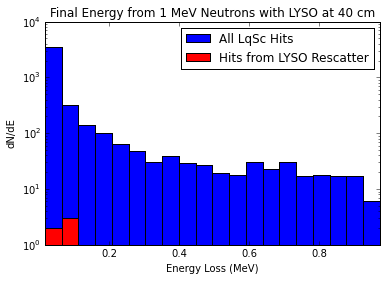

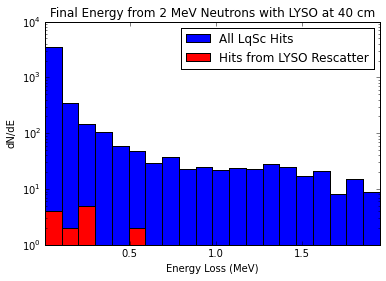

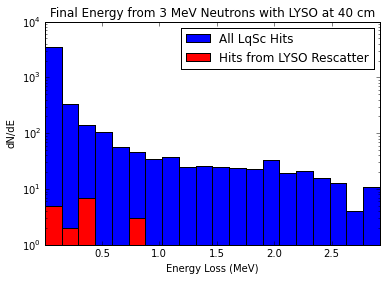

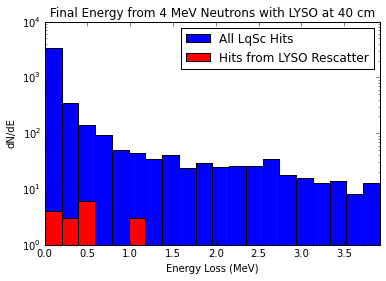

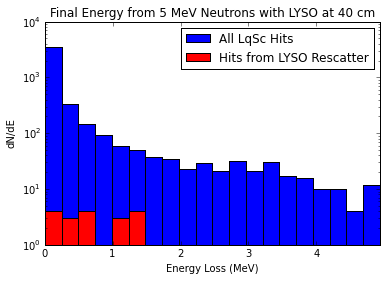

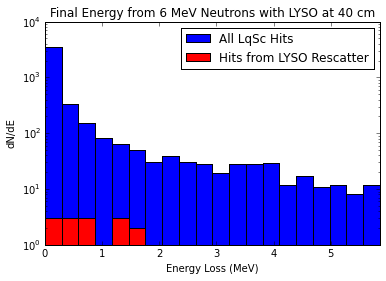

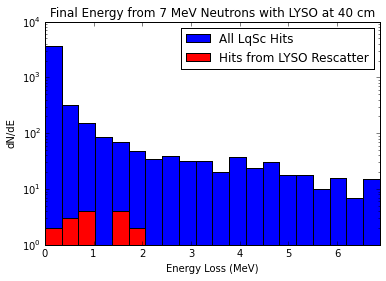

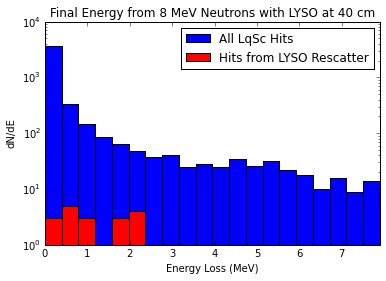

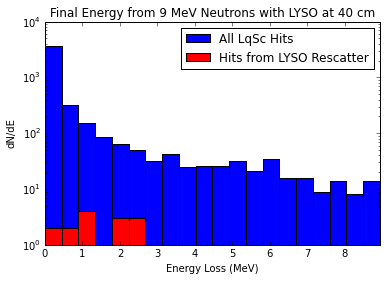

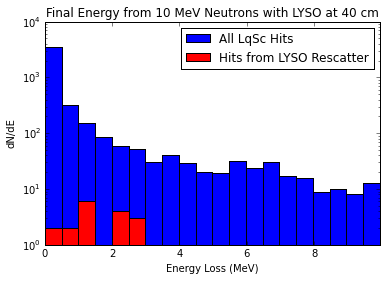

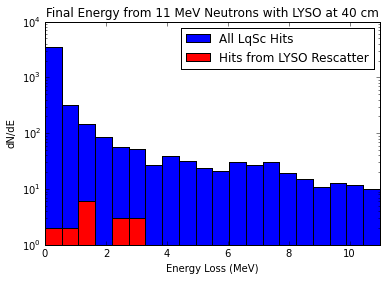

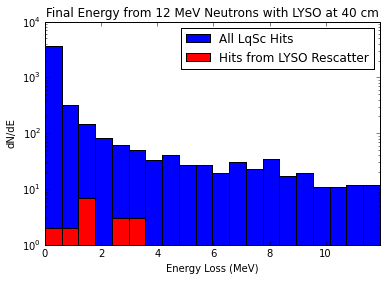

In [5]:
energy_value = 10
print energy_histograms.shape
for energy_value in range(1,13):
    left_bins = energy_histograms[energy_value,:,0].copy()
    left_bins *= 10**(3)
    total_values = energy_histograms[energy_value,:,1]
    polution_values = energy_histograms[energy_value,:,2]
    d_bin = left_bins[1] - left_bins[0]

    plt.bar(left_bins,total_values,width=d_bin, label='All LqSc Hits', log=True)
    plt.bar(left_bins,polution_values,width=d_bin, color='red', label='Hits from LYSO Rescatter')
    plt.legend(loc=0)
    plt.title("Final Energy from {} MeV Neutrons with LYSO at 40 cm".format(energy_value))
    plt.ylim(0,10000)
    plt.xlim(left_bins[0],left_bins[-1]+d_bin)
    plt.xlabel('Energy Loss (MeV)')
    plt.ylabel('dN/dE')
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    savefig("final_energy_{}MeV_neutrons_LYSO_40cm".format(energy_value))
    show()



(12, 2)


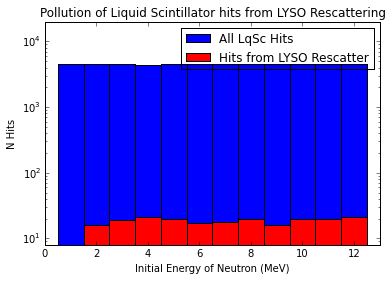

In [6]:
print counts_in_lqsc.shape
ratio = counts_in_lqsc[:,1]/counts_in_lqsc[:,0].astype(float) 
plt.bar([n+0.5 for n in range(12)],counts_in_lqsc[:,0], width=1, log=True, label='All LqSc Hits')
plt.bar([n+0.5 for n in range(12)],counts_in_lqsc[:,1], width=1, color='red', label='Hits from LYSO Rescatter')
plt.title("Pollution of Liquid Scintillator hits from LYSO Rescattering".format(energy_value))
plt.xlim(0,13)
plt.ylim(0,20000)
plt.xlabel("Initial Energy of Neutron (MeV)")
plt.ylabel('N Hits')
plt.legend(loc=0)
savefig("raw_hit_count_comparison_rescatter_LYSO_40cm".format(energy_value))

show()


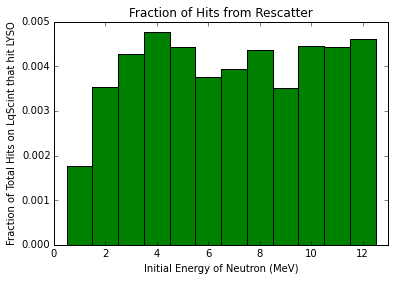

In [7]:
plt.bar([n+0.5 for n in range(12)], ratio, width=1.,color='green')
plt.title("Fraction of Hits from Rescatter")
plt.xlim(0,13)
plt.xlabel("Initial Energy of Neutron (MeV)")
plt.ylabel('Fraction of Total Hits on LqScint that hit LYSO')
savefig("relative_comparison_rescatter_LYSO_40cm".format(energy_value))


In [22]:
print neutrons.entry_data[events_on_both.astype(int)][1]["M_tid"]
print neutrons.entry_data[events_on_both.astype(int)][1]["M_volName"]
print neutrons.entry_data[events_on_both.astype(int)][1]["M_particleName"]
print neutrons.entry_data[events_on_both.astype(int)][1]["M_t"]

[1 1 1 1 1 1 2 3 4 5 6]
['Target' 'MuScV' 'LYSO' 'LiquidSc_Right_Face' 'LiquidSc_Right' 'ScGe_Left'
 'LYSO' 'LYSO' 'LiquidSc_Right' 'LiquidSc_Right' 'LiquidSc_Right']
['neutron' 'neutron' 'neutron' 'neutron' 'neutron' 'neutron' 'Si28' 'O16'
 'proton' 'C12' 'proton']
[  0.00000000e+00   2.63959672e-01   8.57868933e+01   2.33744027e+02
   2.34113951e+02   6.92169784e+02   8.70696361e+01   8.93740319e+01
   2.38076692e+02   2.45868906e+02   2.62440637e+02]


### Look at distributions

In [60]:
# Get the neutron hits
neutron_hits = neutrons.filter_hits("M_particleName", "neutron")
# Get the hits in the lyso
lyso_hits = neutrons.filter_hits("M_volName","LYSO")
# Get neutrons that hit the lyso
lyso_neutron_hits = numpy.intersect1d(neutron_hits, lyso_hits)

# Get the event ID's of these hits
events_neutron_on_lyso = neutrons.hits_entry[lyso_neutron_hits]
print len(events_neutron_on_lyso)

4252


In [64]:
# Get the hits in the left liquid scintillator
lqsc_left_hits = neutrons.filter_hits("M_volName","LiquidSc_Left_Face")
lqsc_right_hits = neutrons.filter_hits("M_volName","LiquidSc_Right_Face")
lqsc_hits = numpy.append(lqsc_left_hits,lqsc_right_hits)
lqsc_hits = numpy.unique(lqsc_hits)

# Get neutrons that hit the lyso
lqsc_neutron_hits = numpy.intersect1d(neutron_hits, lqsc_hits)

# Get the event ID's of these hits
events_neutron_on_lqsc = neutrons.hits_entry[lqsc_neutron_hits]
print len(events_neutron_on_lqsc)

4613


In [65]:
%%timeit
# Variables defined over the whole entry
entry_variables = ["M_nHits", "evt_num", "run_num", "weight"]
# Variables defiend for each hit
hit_variables = list(set(neutrons.entry_data[0].dtype.names) - set(entry_variables))
# Get all names in the correct order
all_names = hit_variables + entry_variables

n_hits = sum(neutrons.entry_data["M_nHits"])
hits_to_events = np.zeros(n_hits)
event_to_hits = np.zeros(neutrons.n_entries)
i=0
for entry in range(neutrons.n_entries):
    event_to_hits[entry] = i
    for hit in range(neutrons.entry_data[entry]["M_nHits"]):
        hits_to_events[i] = entry
        i += 1
hits_to_events = hits_to_events.astype(int)

all_columns = [np.concatenate(neutrons.entry_data[hit_var]) for hit_var in hit_variables]

for ent_var in entry_variables:
    new_column = neutrons.entry_data[ent_var][hits_look_up]
    all_columns.append(new_column)

hits_table = numpy.rec.fromarrays(all_columns, names=(all_names))


0.0359852590505


In [73]:
a = numpy.array([0,0,0,0,0,1,1,1,1,1])
print np.where(a == 1)
print np.where(a[4:] == 1)

(array([5, 6, 7, 8, 9]),)
(array([1, 2, 3, 4, 5]),)
